# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler,StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns


# Import Dataset

In [2]:
train_df= pd.read_csv("train.csv")
test_df= pd.read_csv("test.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
train_df.duplicated().sum()

np.int64(0)

In [5]:
train_df.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
                 ... 
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
Length: 81, dtype: int64

In [6]:
train_df.drop('Id', axis=1, inplace=True)


### Checking the unique numeric values in to segregster it into numerical and categorical columns

In [7]:
values_df = pd.DataFrame(
    [(train_df[col].nunique()) for col in train_df.columns], 
    index=train_df.columns,  # Use column names as index
    columns=['unique_count']  # Name for the count column
).sort_values(by='unique_count', ascending=True)  # Specify the column to sort by

values_df.head(52)

,unique_count
Alley,2
Street,2
Utilities,2
CentralAir,2
MasVnrType,3
GarageFinish,3
BsmtHalfBath,3
LandSlope,3
HalfBath,3
PavedDrive,3


In [8]:
numerical_feat = [column for column in train_df.columns if train_df[column].dtype != 'object']

categorical_feat = [column for column in train_df.columns if train_df[column].dtype == 'object']

categorical_num = ['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 
                      'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                      'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 
                      'MoSold', 'YrSold']

In [9]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Data Visualization

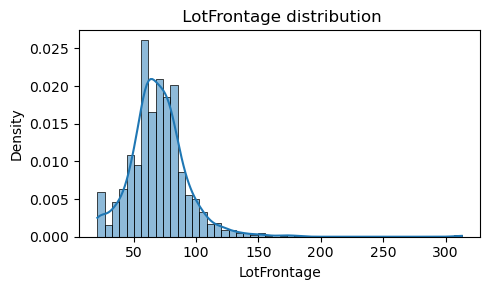

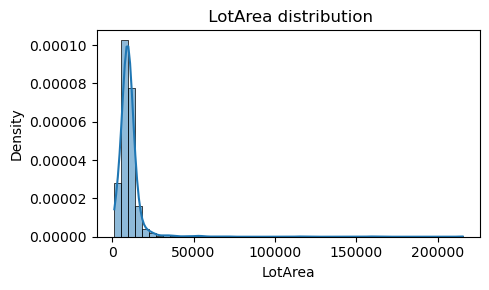

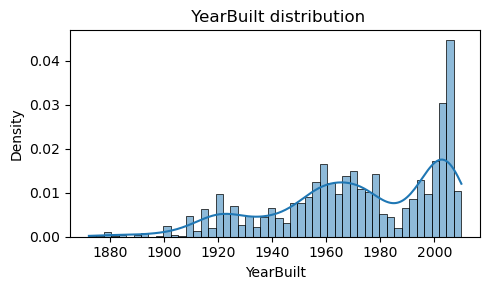

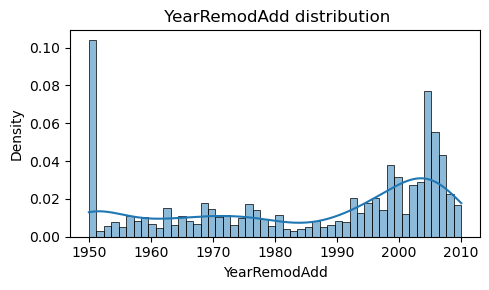

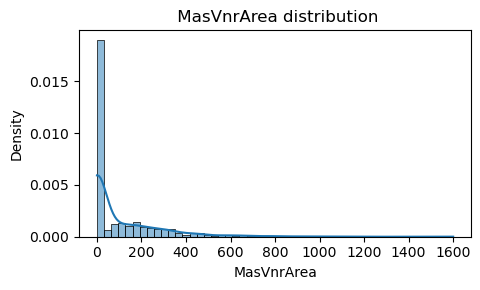

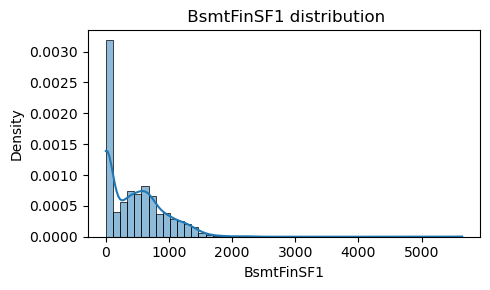

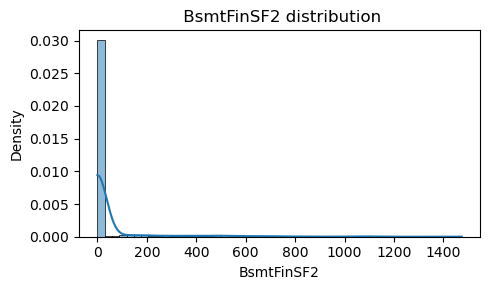

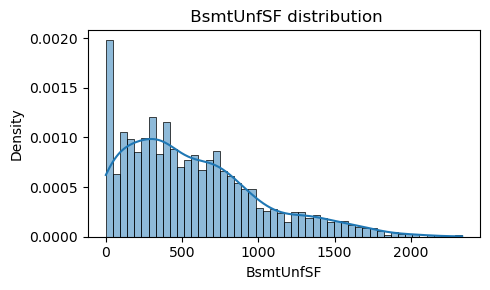

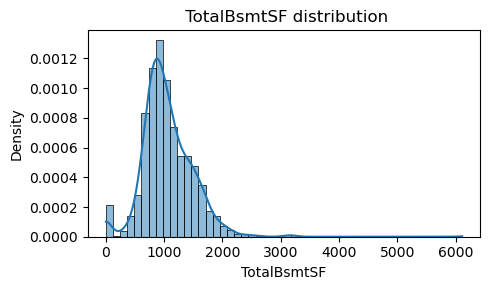

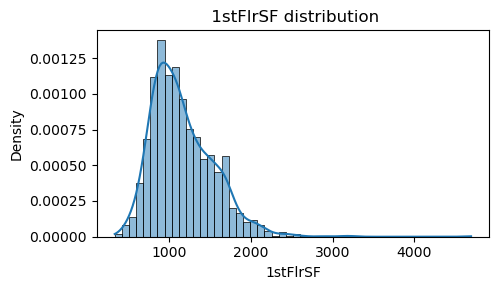

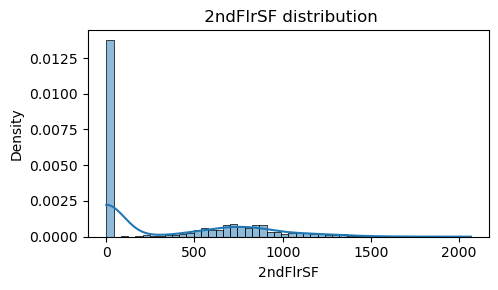

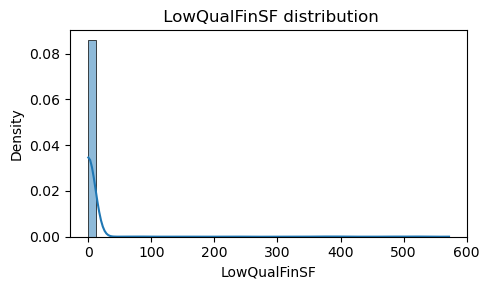

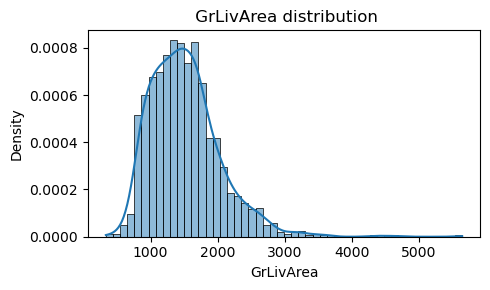

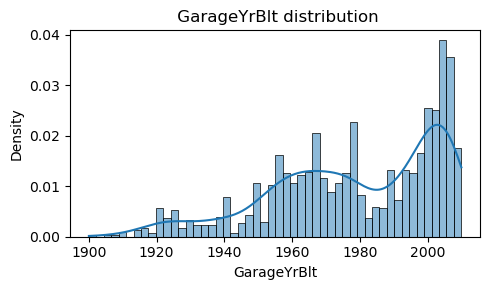

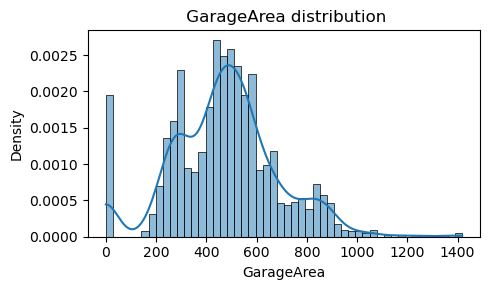

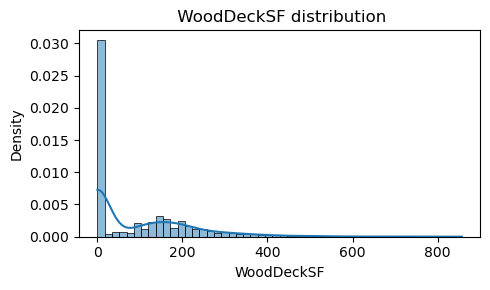

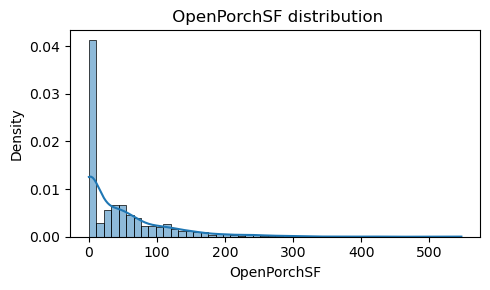

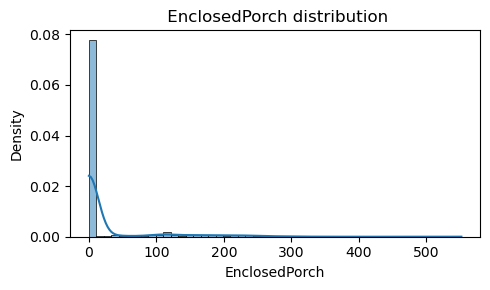

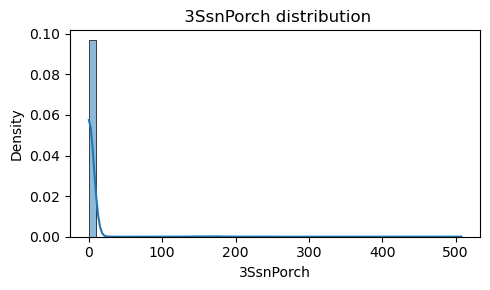

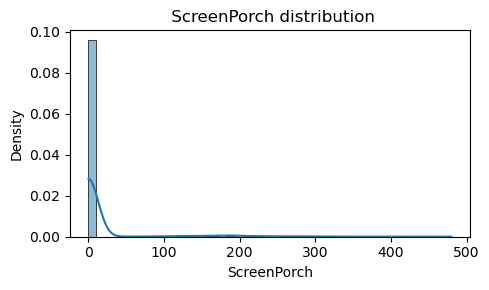

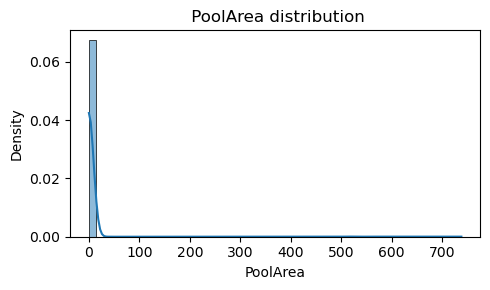

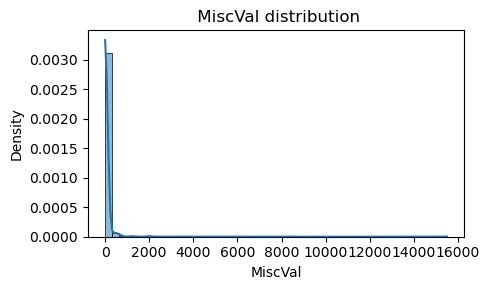

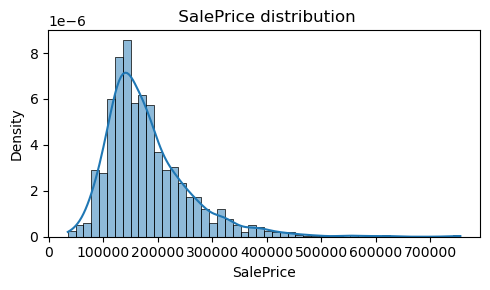

In [10]:
# vizualization for the numerical features that are continous
cont_num_feat = []
for col in numerical_feat:
    if col not in categorical_num:
        cont_num_feat.append(col)

for col in cont_num_feat:
    plt.figure(figsize=(5, 3))
    sns.histplot(data=train_df[col], bins=50, kde=True, stat='density')
    plt.title(f" {col} distribution")
    plt.tight_layout()
    plt.show()

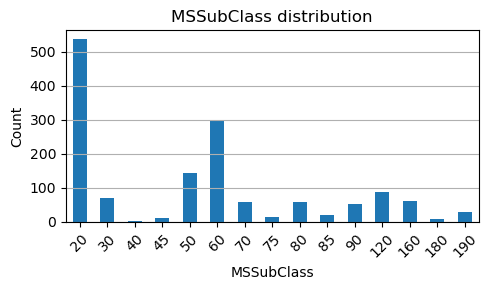

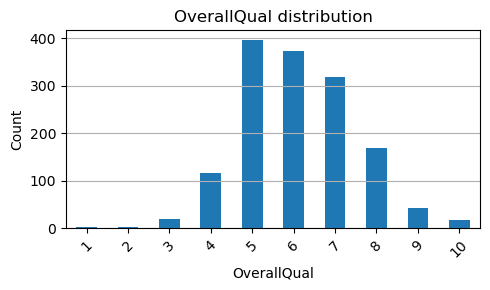

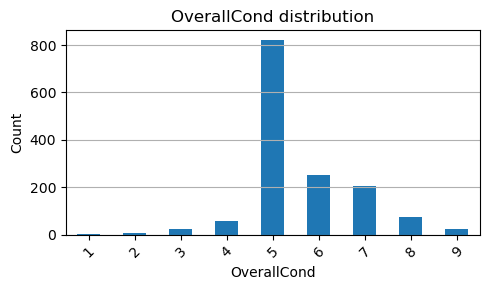

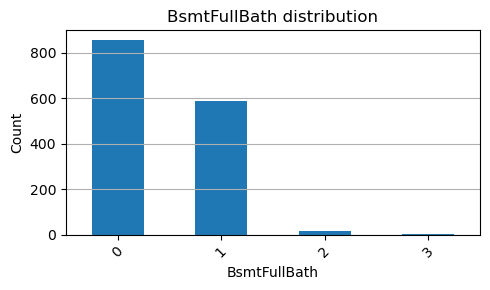

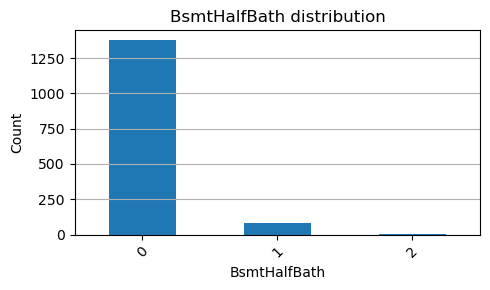

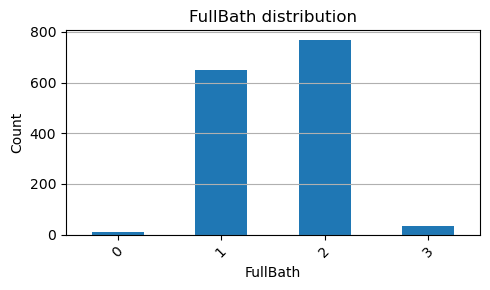

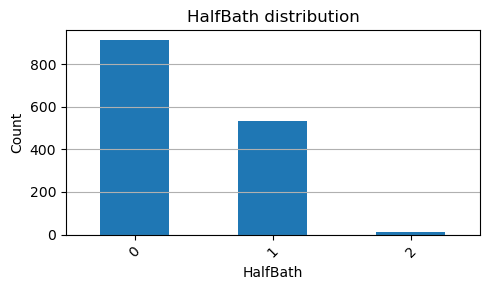

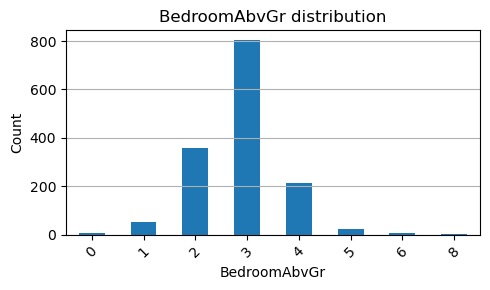

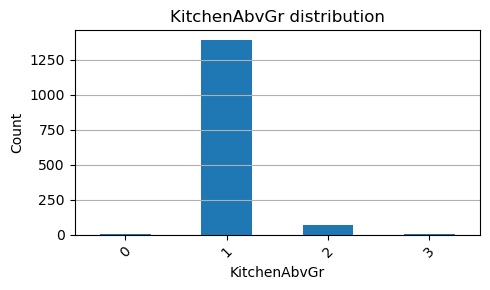

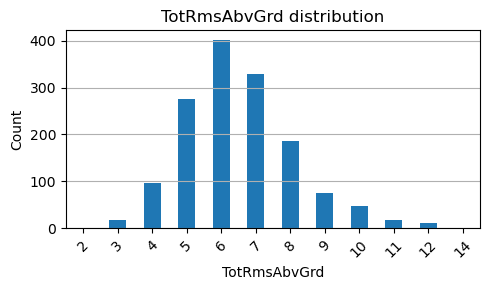

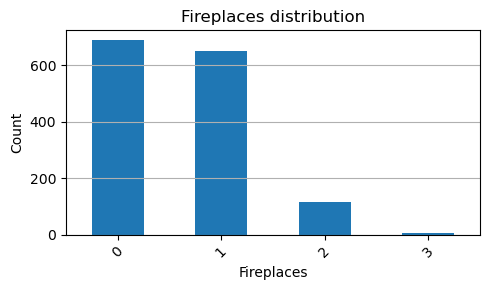

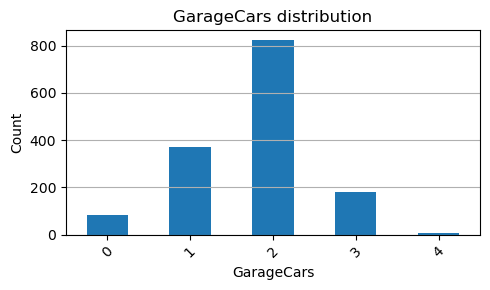

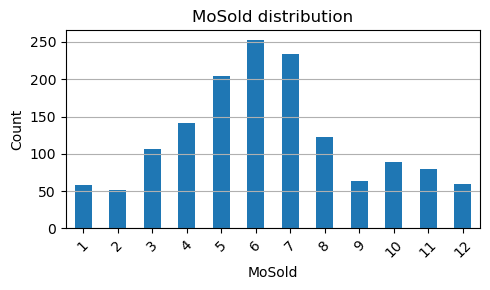

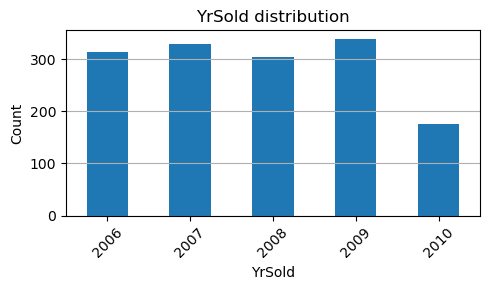

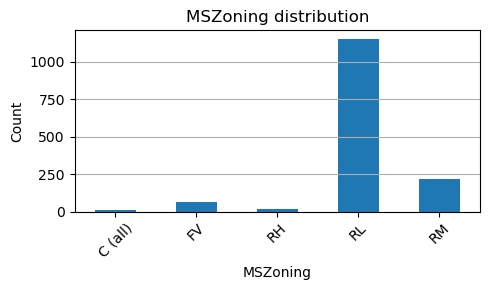

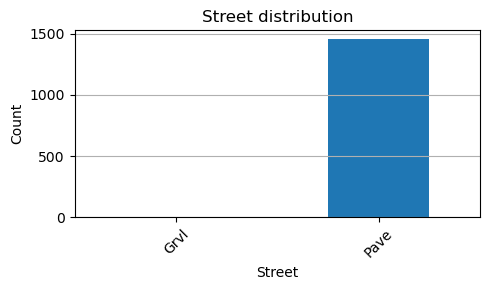

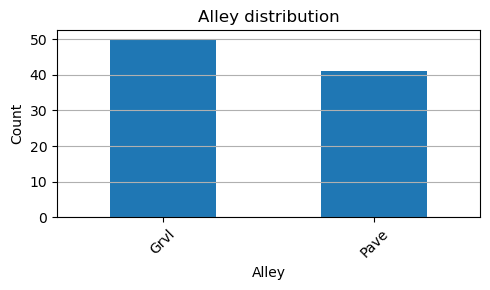

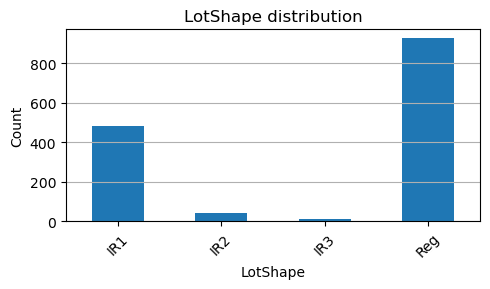

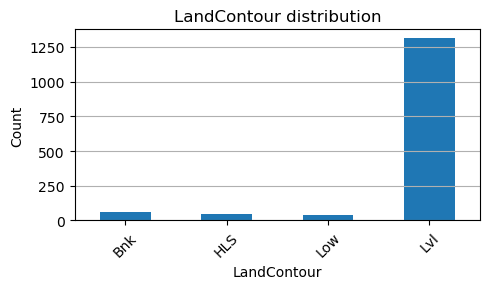

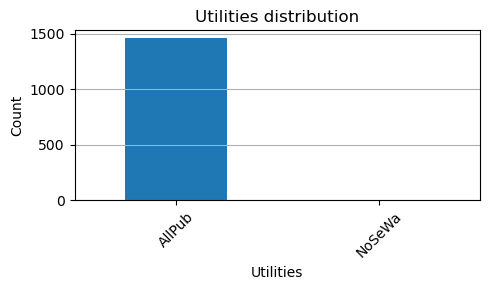

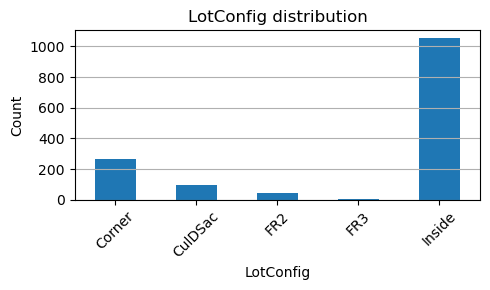

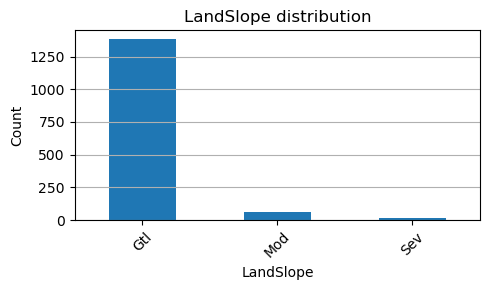

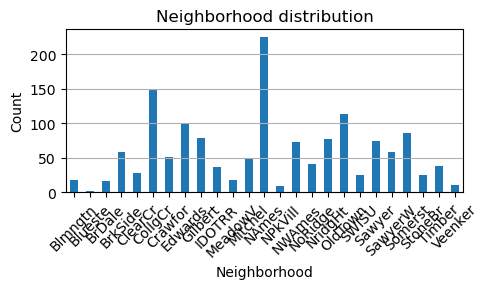

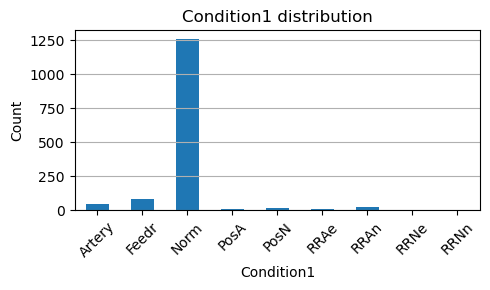

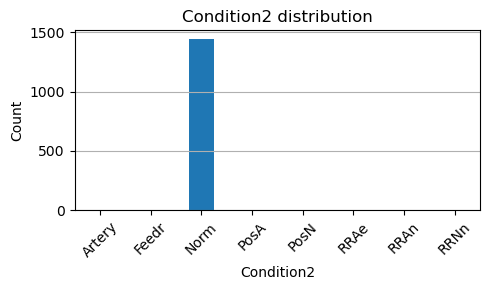

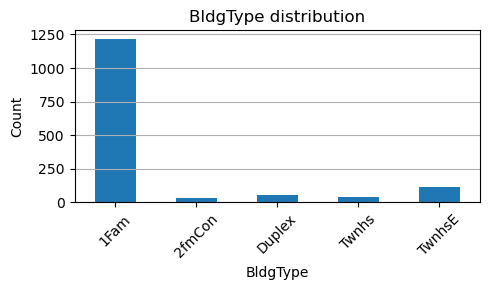

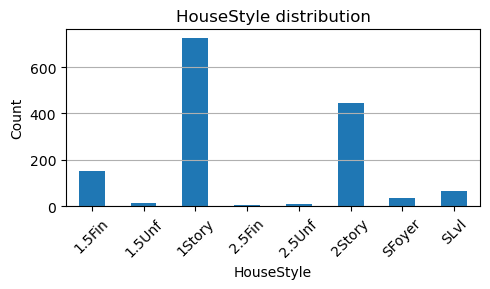

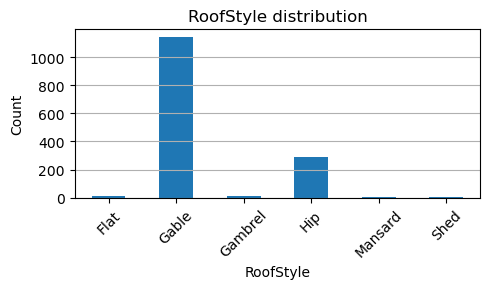

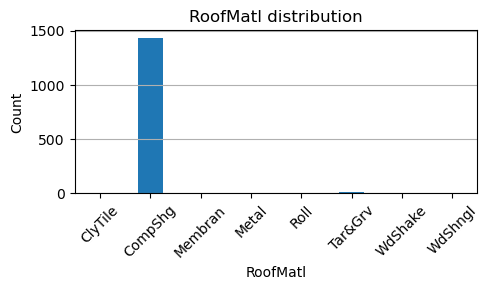

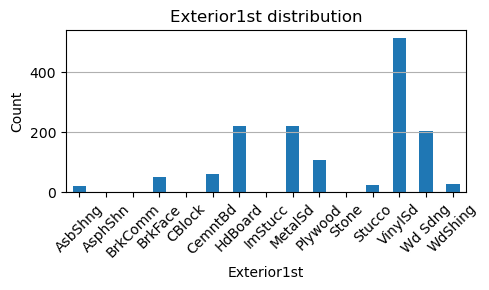

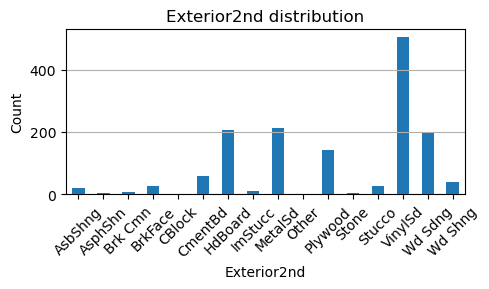

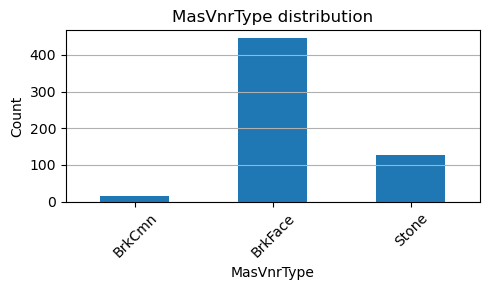

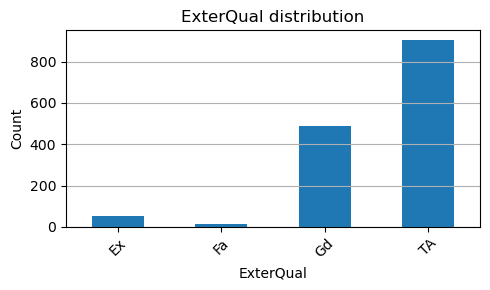

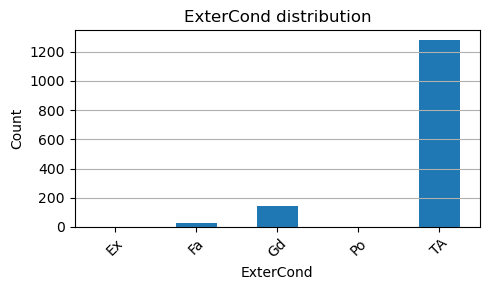

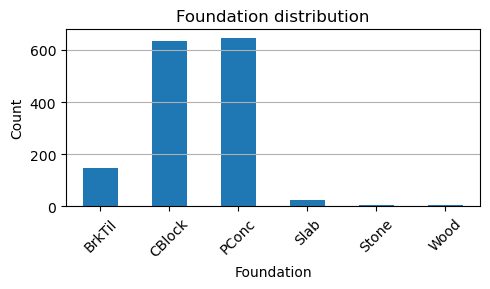

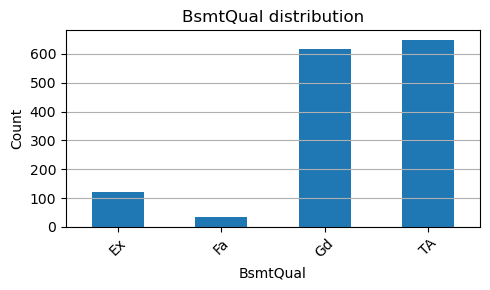

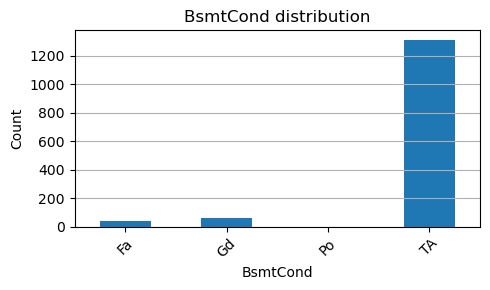

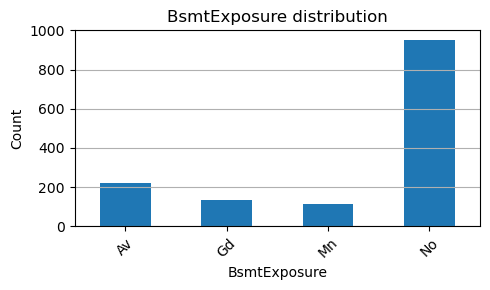

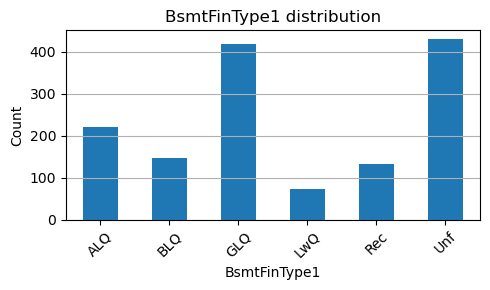

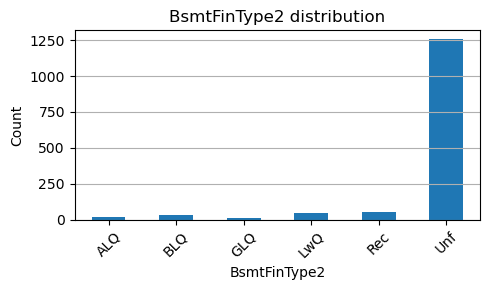

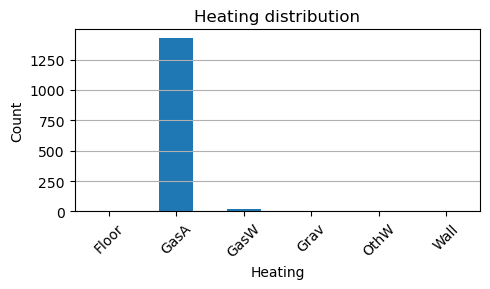

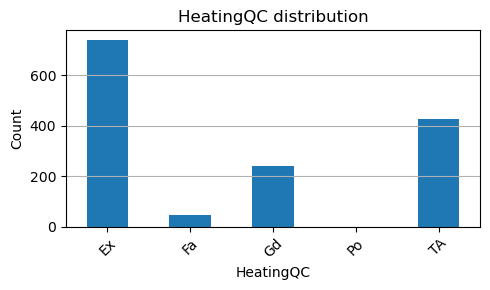

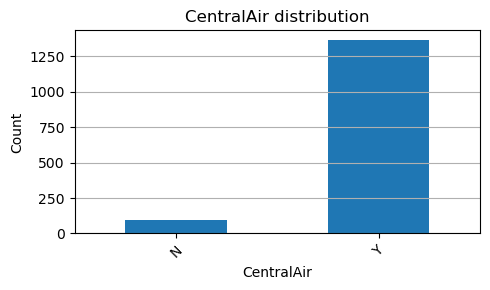

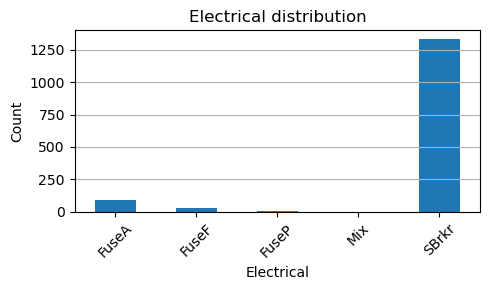

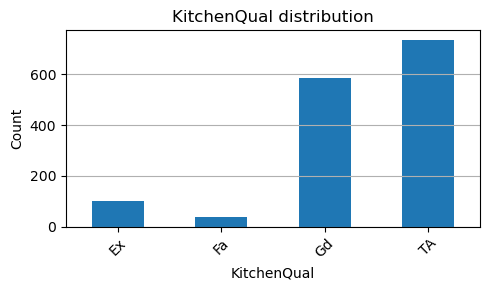

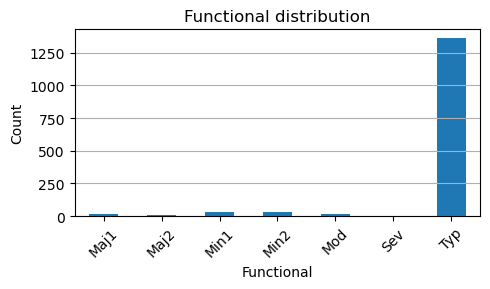

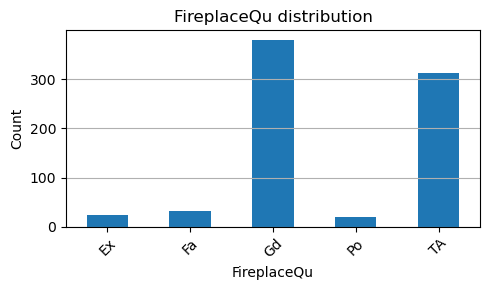

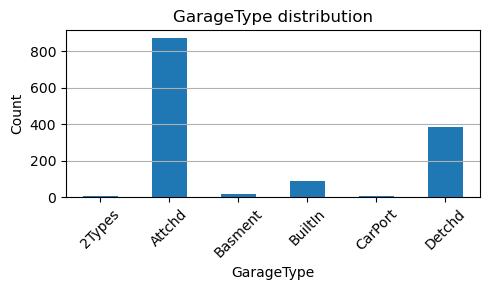

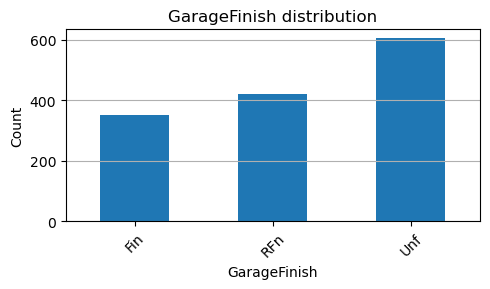

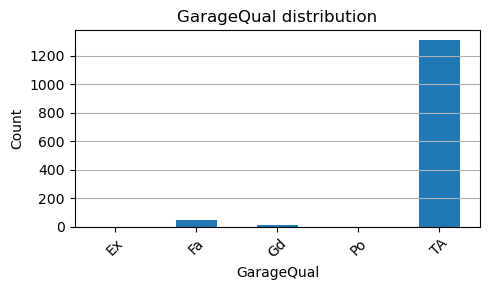

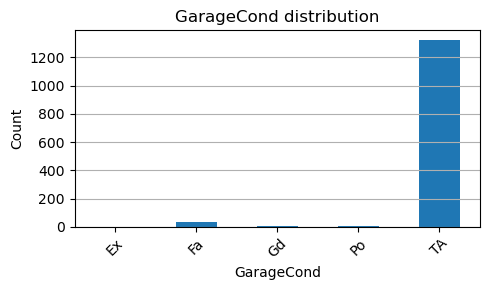

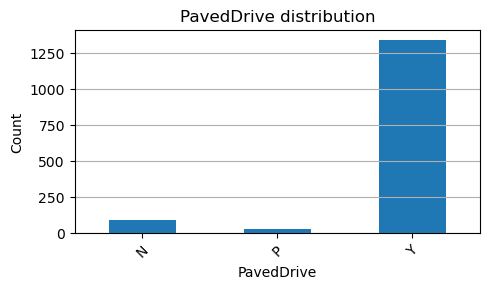

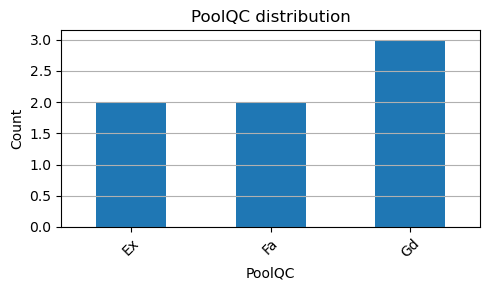

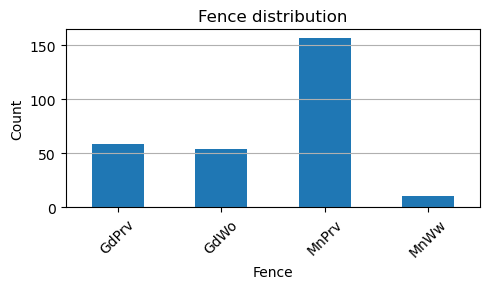

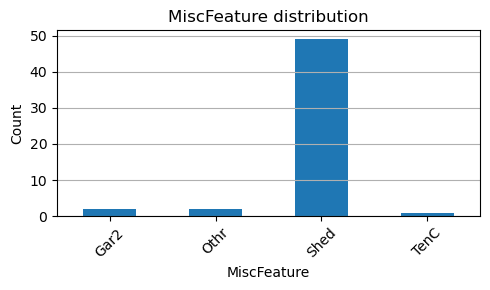

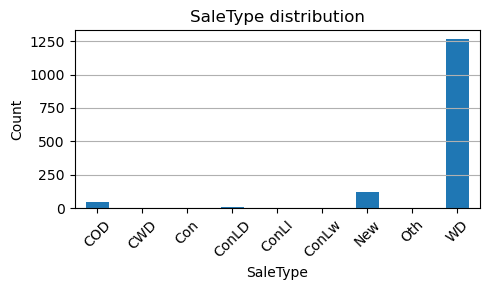

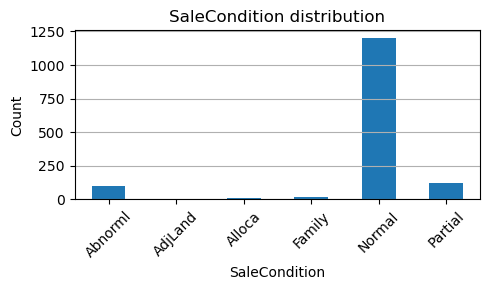

In [11]:
for col in categorical_num + categorical_feat:
    if col in train_df.columns:
        plt.figure(figsize=(5, 3))
        
        counts = train_df[col].value_counts().sort_index()
        counts.plot(kind='bar')
        
        plt.title(f'{col} distribution')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

# Correlation Matrix

In [12]:
#Corelations Score with the Target Variable
corr_matrix = train_df.corr(numeric_only=True)
target_scores = corr_matrix['SalePrice'].sort_values(ascending=False)

target_scores

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

<Axes: >

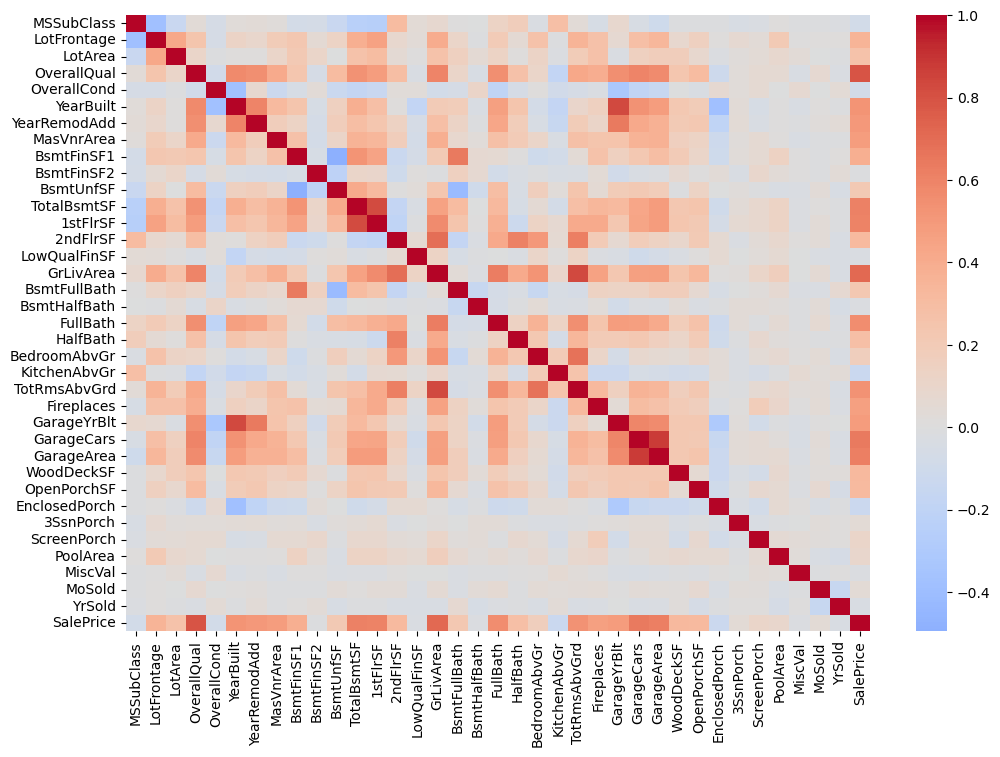

In [13]:
# Heat Map of the Correlations Matrix

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)

# Feature Engineering

In [14]:
# Feature Engg. after considering the correlations score and the heat map

train_df['BsmtFinTotal'] = train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
train_df['TotalLivingArea'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['LowQualFinSF']

train_df.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF',
                 'LowQualFinSF','TotalBsmtSF','GrLivArea','BsmtQual','BldgType'], axis=1, inplace=True)

In [15]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSo

In [16]:
# training the data by spliting the "train_df" data and i will be checking the accuracy of the whole project on the "test_df"

X=train_df.drop('SalePrice', axis=1)
y=train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Pipelines for both numeircal and categorical features

In [17]:
#
numerical_feat = [column for column in X.columns if train_df[column].dtype != 'object']
# numerical_feat.remove('SalePrice')

categorical_feat = [column for column in X.columns if train_df[column].dtype == 'object']

# Numerical pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", RobustScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combining in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_feat),
        ('cat', categorical_transformer, categorical_feat)
    ]
)

# Feature Selector to only select effective features

In [18]:
feature_selector = SelectFromModel(LassoCV(cv=5, random_state=42, n_jobs=-1), threshold=0.01)

# Main Models and Its Pipeline

In [19]:
models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XG Boosting': XGBRegressor(n_estimators=100, random_state=42)
}

# Evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('selector', feature_selector),
                               ('model', model)])

    # Fit model
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred_test = pipeline.predict(X_test)
    #y_pred_train = pipeline.predict(X_train)

    # Metrics
    r2 = r2_score(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)

    print(f"{model.__class__.__name__}")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}\n")
    return r2, rmse, mae

In [20]:
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    r2, rmse, mae = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {'R2': r2, 'RMSE': rmse, 'MAE': mae}

Evaluating Linear Regression...
LinearRegression
R2 Score: 0.8663
RMSE: 32021.53
MAE: 19711.36

Evaluating SVR...
SVR
R2 Score: -0.0250
RMSE: 88666.89
MAE: 59567.47

Evaluating Ridge Regression...
Ridge
R2 Score: 0.8662
RMSE: 32035.77
MAE: 19672.72

Evaluating Lasso Regression...
Lasso
R2 Score: 0.8663
RMSE: 32022.19
MAE: 19709.36

Evaluating Decision Tree...
DecisionTreeRegressor
R2 Score: 0.7991
RMSE: 39254.70
MAE: 26883.75

Evaluating Random Forest...
RandomForestRegressor
R2 Score: 0.8835
RMSE: 29890.33
MAE: 17955.70

Evaluating Gradient Boosting...
GradientBoostingRegressor
R2 Score: 0.8982
RMSE: 27949.79
MAE: 17344.00

Evaluating XG Boosting...
XGBRegressor
R2 Score: 0.9009
RMSE: 27576.32
MAE: 18214.91



# Cross-Validation for differnt types of models

In [21]:
from sklearn.model_selection import cross_validate, KFold

model = GradientBoostingRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('selector', feature_selector),
                               ('model', model)])

# Defining cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Performing cross-validation
results = cross_validate(
    estimator=pipeline,      
    X=X_train,             # features
    y=y_train,             # target
    cv=cv,                 # cross-validation splitter (KFold, StratifiedKFold, etc.)
    scoring=['r2','neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

results

{'fit_time': array([0.48081064, 0.49961543, 0.54041743, 0.5196774 , 0.46743989]),
 'score_time': array([0.01353431, 0.01365852, 0.01322031, 0.01304269, 0.01381493]),
 'test_r2': array([0.88685366, 0.80325975, 0.76772889, 0.88057787, 0.90248454]),
 'train_r2': array([0.96629867, 0.9650897 , 0.96519881, 0.9644032 , 0.96203228]),
 'test_neg_root_mean_squared_error': array([-27043.603156  , -33934.99030881, -39551.49661951, -25530.46639929,
        -22680.96522747]),
 'train_neg_root_mean_squared_error': array([-14027.47232815, -14461.13073373, -14166.01177567, -14722.31389936,
        -15263.54298021])}

In [22]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('selector', feature_selector),
                               ('model', model)])

# Defining cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Performing cross-validation
results = cross_validate(
    estimator=pipeline,      
    X=X_train,             # features
    y=y_train,             # target
    cv=cv,                 # cross-validation splitter (KFold, StratifiedKFold, etc.)
    scoring=['r2','neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)
results

{'fit_time': array([1.1358583 , 1.09987187, 1.16616631, 1.18355584, 1.02308941]),
 'score_time': array([0.02439165, 0.02208138, 0.02024865, 0.02144337, 0.02998281]),
 'test_r2': array([0.86755169, 0.77185322, 0.76228309, 0.87035629, 0.85254029]),
 'train_r2': array([0.9734152 , 0.97320968, 0.97700534, 0.967755  , 0.9725946 ]),
 'test_neg_root_mean_squared_error': array([-29259.54077755, -36543.34446051, -40012.47057694, -26600.63902805,
        -27890.83345969]),
 'train_neg_root_mean_squared_error': array([-12458.69638859, -12668.18341973, -11515.0011926 , -14012.05268951,
        -12967.79593266])}

In [23]:
model = Lasso()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('selector', feature_selector),
                               ('model', model)])

# Defining cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Performing cross-validation
results = cross_validate(
    estimator=pipeline,      
    X=X_train,             # features
    y=y_train,             # target
    cv=cv,                 # cross-validation splitter (KFold, StratifiedKFold, etc.)
    scoring=['r2','neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)


results

{'fit_time': array([0.16493058, 0.16321683, 0.19541287, 0.1870656 , 0.18210363]),
 'score_time': array([0.01243138, 0.01159048, 0.02051759, 0.01253414, 0.01822495]),
 'test_r2': array([0.85917624, 0.78169852, 0.68381575, 0.85439614, 0.84735114]),
 'train_r2': array([0.86394725, 0.85518821, 0.87852246, 0.83823637, 0.84661202]),
 'test_neg_root_mean_squared_error': array([-30170.48319851, -35746.1656766 , -46146.14683087, -28190.500442  ,
        -28377.33353969]),
 'train_neg_root_mean_squared_error': array([-28184.4495611 , -29452.85408215, -26466.62185778, -31384.19840406,
        -30679.18003206])}

## Selecting Lasso because of good performance across all folds in CV

In [24]:
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('selector', feature_selector),
                                 ('model', Lasso(max_iter=10000, random_state=42))])


param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}


grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=5, 
                           scoring='neg_mean_squared_error', n_jobs=-1)


grid_search.fit(X_train, y_train)


best_lasso_model = grid_search.best_estimator_
best_params = grid_search.best_params_


y_pred_test = best_lasso_model.predict(X_test)
y_pred_train = best_lasso_model.predict(X_train)

# Calculate metrics for the best model
# Metrics for Train Data
r2_train = r2_score(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)

# Metrics for Test data
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

# Print the results
print(f"Best model: {best_lasso_model.named_steps['model'].__class__.__name__}")
print(f"Best Hyperparameters: {best_params}\n")

print("Results for train data")
print(f"R2 Score: {r2_train:.4f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}\n")

print("Results for test data")
print(f"R2 Score: {r2_test:.4f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAE: {mae_test:.2f}\n")

Best model: Lasso
Best Hyperparameters: {'model__alpha': 100}

Results for train data
R2 Score: 0.8540
RMSE: 29514.10
MAE: 18003.71

Results for test data
R2 Score: 0.8658
RMSE: 32084.11
MAE: 19554.49



# Saving the final pipleine and preprocessor

In [25]:
import joblib


# Using the best model with best parameters
best_model = Lasso(max_iter=10000,
                   random_state=42,
                   alpha=100
                  )


final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', feature_selector),
    ('model', best_model)
])


final_pipeline.fit(X_train, y_train)


joblib.dump(final_pipeline, 'best_Lasso_pipeline.joblib')
joblib.dump(preprocessor, 'preprocessor.joblib')  

print(" Best model saved as 'best_lasso_pipeline.joblib'")



 Best model saved as 'best_lasso_pipeline.joblib'


# Checking the results on the untouched test data

In [26]:
y_pred = final_pipeline.predict(X_test)

In [27]:
# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")

RMSE: 32084.11
R²: 0.866
MAE: 19554.49


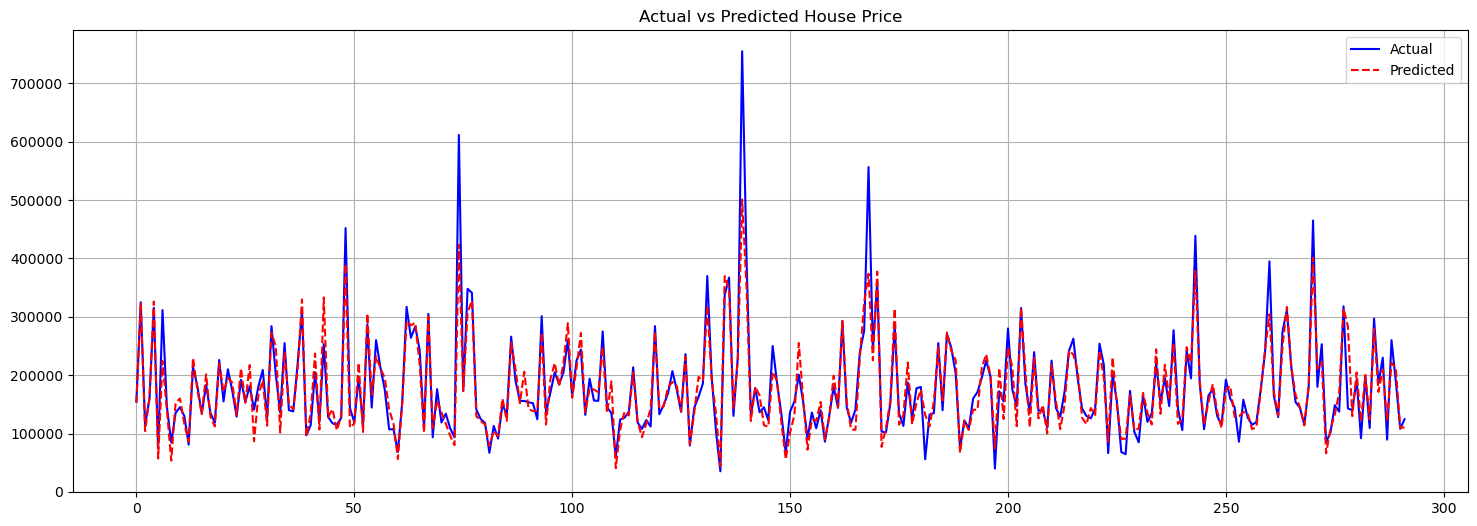

In [28]:
plt.figure(figsize=(18, 6))
plt.plot(y_test.values, label = "Actual", color = "blue")
plt.plot(y_pred, label = "Predicted", color = "red", linestyle = "--")
plt.title("Actual vs Predicted House Price")
plt.legend()
plt.grid(True)
plt.show()

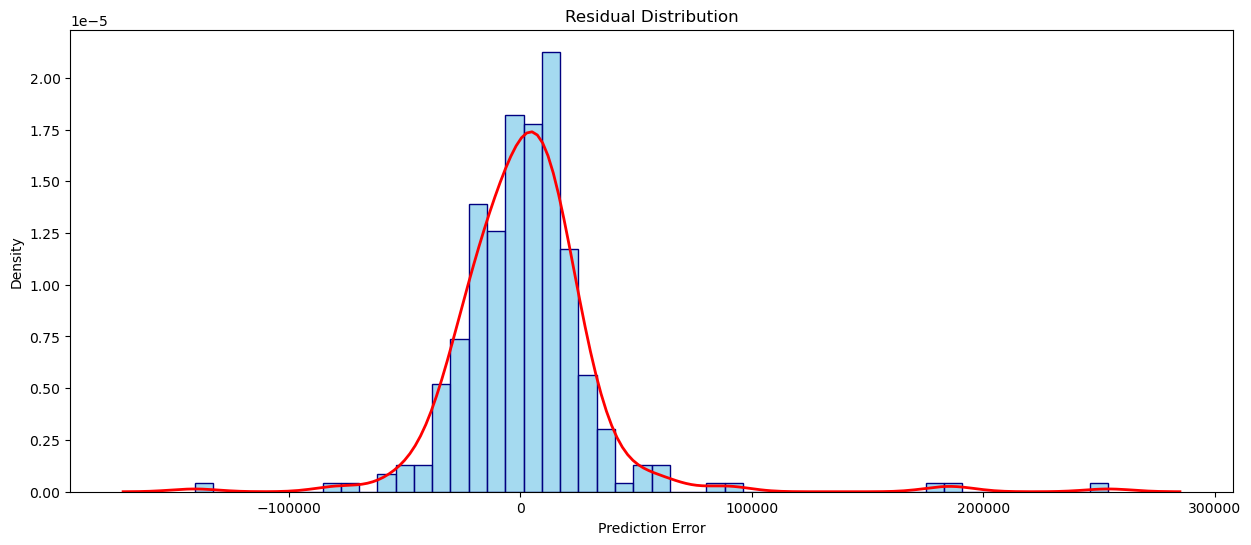

In [29]:
#Residual Distribution

resid = y_test - y_pred

plt.figure(figsize=(15, 6))
ax = sns.histplot(resid, bins=50, color='skyblue', edgecolor='navy', stat='density')
sns.kdeplot(resid, color='red', linewidth=2, ax=ax)

plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.show()


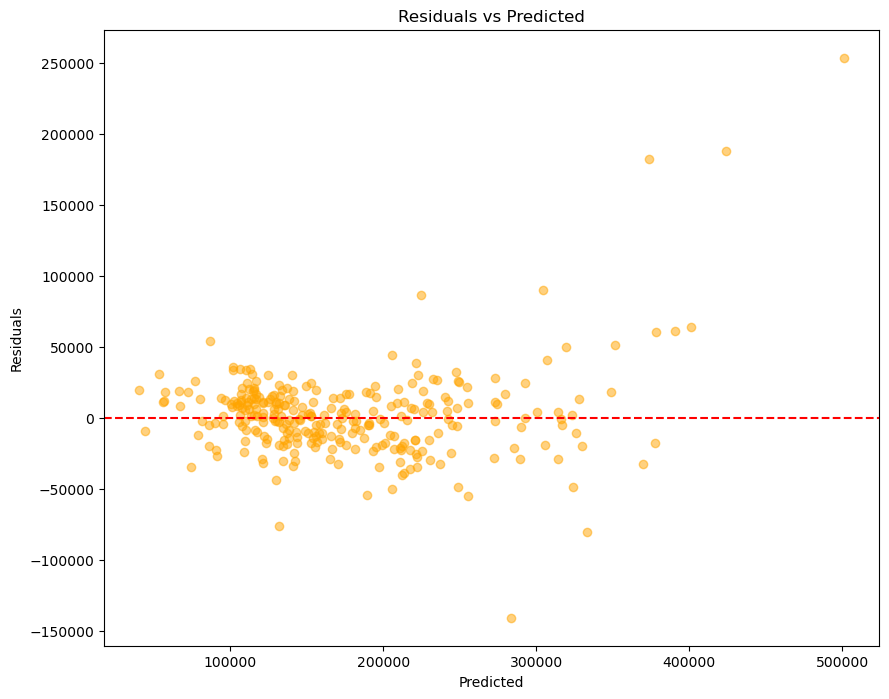

In [30]:
#  Residual Plot

plt.figure(figsize=(10, 8))
plt.scatter(y_pred, resid, color= 'orange', alpha=0.5 )
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()